In [1]:
!pip install -q eccd_datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 12.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion()   # interactive mode




In [3]:
import io
import pandas as pd
import requests
import torchvision.transforms.v2 as transforms
from eccd_datasets import load_images

In [4]:
# Download the original lables used when training a resnet

resnet_labels = {
    int(index): label
    for index, (id, label) in requests.get(
        "https://files.fast.ai/models/imagenet_class_index.json"
    )
    .json()
    .items()
}
resnet_labels[10]

'brambling'

In [5]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [6]:
df_images['coarse_cat'].value_counts()

,count
coarse_cat,
Apple,852
Melon,480
Pear,337
Satsumas,211
Orange,174


In [7]:
print(df_images.shape)


(2054, 4)


In [8]:
df_images['dataset'].value_counts()

,count
dataset,
test,1322
train,675
val,57


In [9]:
import os

# Define the base directory for your dataset
dataset_dir = 'fruits_dataset'

# Create the base directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

# Create subdirectories for 'train' and 'val'
for split in ['train', 'val', "test"]:
  os.makedirs(os.path.join(dataset_dir, split), exist_ok=True)
  # Create subdirectories for each class within 'train' and 'val'
  for coarse_cat in df_images['coarse_cat'].unique():
    os.makedirs(os.path.join(dataset_dir, split, coarse_cat), exist_ok=True)


# Iterate through the DataFrame and save images
for index, row in df_images.iterrows():
  # Determine the split (train or val) based on the 'dataset' column
  split = row['dataset']

  # Get the image data and class label
  image_data = row['image_data']
  coarse_cat = row['coarse_cat']

  # Open the image using PIL
  image = Image.open(io.BytesIO(image_data))

  # Define the save path
  save_path = os.path.join(dataset_dir, split, coarse_cat, f'{index}.jpg')

  # Save the image
  image.save(save_path)

In [10]:
# Directorio
base_dir = '/content/fruits_dataset'

for dataset_type in ['train', 'val', 'test']:
    for category in df_images['coarse_cat'].unique():
        os.makedirs(os.path.join(base_dir, dataset_type, category), exist_ok=True)

for idx, row in df_images.iterrows():
    img_data = row['image_data']
    category = row['coarse_cat']   # Categoría
    dataset_type = row['dataset']
    image = Image.open(io.BytesIO(img_data))
    file_name = os.path.join(base_dir, dataset_type, category, f'{idx}.jpg')

    image.save(file_name, format='JPEG')

In [11]:
# Data normalization for training

data_transforms = {
'train': transforms.Compose([
transforms.RandomResizedCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'test': transforms.Compose([
transforms.Resize(256),
transforms.CenterCrop(224),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

data_dir = '/content/fruits_dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


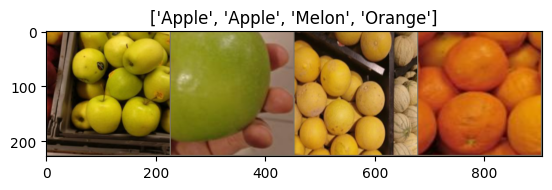

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    # Move inputs and labels to the correct device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Zero the parameter gradients
                    optimizer.zero_grad()

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # Backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model


In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 96.7MB/s]


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0719 Acc: 0.6252
val Loss: 0.8520 Acc: 0.7368

Epoch 1/24
----------
train Loss: 0.7001 Acc: 0.7407
val Loss: 0.5344 Acc: 0.7895

Epoch 2/24
----------
train Loss: 0.6151 Acc: 0.7778
val Loss: 0.4556 Acc: 0.8421

Epoch 3/24
----------
train Loss: 0.4160 Acc: 0.8489
val Loss: 0.3689 Acc: 0.8947

Epoch 4/24
----------
train Loss: 0.4304 Acc: 0.8356
val Loss: 0.3269 Acc: 0.8596

Epoch 5/24
----------
train Loss: 0.3862 Acc: 0.8667
val Loss: 0.3516 Acc: 0.8772

Epoch 6/24
----------
train Loss: 0.3267 Acc: 0.8948
val Loss: 0.1538 Acc: 0.9298

Epoch 7/24
----------
train Loss: 0.2330 Acc: 0.9156
val Loss: 0.1405 Acc: 0.9649

Epoch 8/24
----------
train Loss: 0.2126 Acc: 0.9274
val Loss: 0.1241 Acc: 0.9474

Epoch 9/24
----------
train Loss: 0.1983 Acc: 0.9304
val Loss: 0.0901 Acc: 0.9649

Epoch 10/24
----------
train Loss: 0.1793 Acc: 0.9496
val Loss: 0.1135 Acc: 0.9298

Epoch 11/24
----------
train Loss: 0.2344 Acc: 0.9304
val Loss: 0.1429 Acc: 0.9298

Ep

<ipython-input-13-e5688ae9ca81>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [17]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f'Input features: {input_last_layer}')
print(f'Output features: {output_last_layer}')


Input features: 512
Output features: 1000


In [18]:
number_of_classes = df_images['coarse_cat'].nunique()
model_ft.fc= nn.Linear(in_features=input_last_layer, out_features=number_of_classes)

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f'Input features: {input_last_layer}')
print(f'Output features: {output_last_layer}')

Input features: 512
Output features: 5


In [19]:
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [20]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8652 Acc: 0.6711
val Loss: 0.2861 Acc: 0.8947

Epoch 1/24
----------
train Loss: 0.6287 Acc: 0.7600
val Loss: 0.5690 Acc: 0.8421

Epoch 2/24
----------
train Loss: 0.5658 Acc: 0.8030
val Loss: 0.2118 Acc: 0.8772

Epoch 3/24
----------
train Loss: 0.6125 Acc: 0.7985
val Loss: 0.1020 Acc: 0.9649

Epoch 4/24
----------
train Loss: 0.5009 Acc: 0.8089
val Loss: 0.6159 Acc: 0.7895

Epoch 5/24
----------
train Loss: 0.4504 Acc: 0.8444
val Loss: 0.2461 Acc: 0.8947

Epoch 6/24
----------
train Loss: 0.4660 Acc: 0.8474
val Loss: 0.3914 Acc: 0.8596

Epoch 7/24
----------
train Loss: 0.3094 Acc: 0.8904
val Loss: 0.2332 Acc: 0.8947

Epoch 8/24
----------
train Loss: 0.1929 Acc: 0.9304
val Loss: 0.1265 Acc: 0.9649

Epoch 9/24
----------
train Loss: 0.2871 Acc: 0.9052
val Loss: 0.1249 Acc: 0.9474

Epoch 10/24
----------
train Loss: 0.1971 Acc: 0.9230
val Loss: 0.1073 Acc: 0.9649

Epoch 11/24
----------
train Loss: 0.1674 Acc: 0.9467
val Loss: 0.1123 Acc: 0.9649

Ep

<ipython-input-13-e5688ae9ca81>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


In [21]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f'Input features: {input_last_layer}')
print(f'Output features: {output_last_layer}')


number_of_classes = df_images['coarse_cat'].nunique()
model_ft.fc= nn.Linear(in_features=input_last_layer, out_features=number_of_classes)

input_last_layer = model_ft.fc.in_features
output_last_layer = model_ft.fc.out_features
print(f'Input features: {input_last_layer}')
print(f'Output features: {output_last_layer}')

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Input features: 512
Output features: 1000
Input features: 512
Output features: 5
Epoch 0/24
----------
train Loss: 0.9735 Acc: 0.6163
val Loss: 0.6405 Acc: 0.8421

Epoch 1/24
----------
train Loss: 0.6547 Acc: 0.7644
val Loss: 0.2698 Acc: 0.8596

Epoch 2/24
----------
train Loss: 0.4426 Acc: 0.8459
val Loss: 0.9139 Acc: 0.7895

Epoch 3/24
----------
train Loss: 0.4584 Acc: 0.8341
val Loss: 0.9134 Acc: 0.7368

Epoch 4/24
----------
train Loss: 0.4988 Acc: 0.8370
val Loss: 0.4824 Acc: 0.8596

Epoch 5/24
----------
train Loss: 0.4609 Acc: 0.8504
val Loss: 0.2388 Acc: 0.9123

Epoch 6/24
----------
train Loss: 0.4054 Acc: 0.8593
val Loss: 0.2174 Acc: 0.9123

Epoch 7/24
----------
train Loss: 0.2334 Acc: 0.9185
val Loss: 0.1742 Acc: 0.9123

Epoch 8/24
----------
train Loss: 0.2685 Acc: 0.9244
val Loss: 0.1185 Acc: 0.9298

Epoch 9/24
----------
train Loss: 0.1913 Acc: 0.9437
val Loss: 0.1728 Acc: 0.9123

Epoch 10/24
----------
train Loss: 0.2020 Acc: 0.9422
val Loss: 0.1881 Acc: 0.9123

Epoch

<ipython-input-13-e5688ae9ca81>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Train and evaluate

visualize model

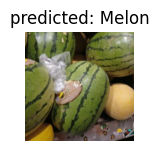

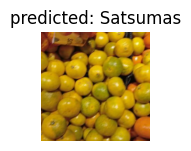

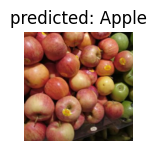

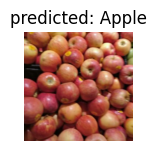

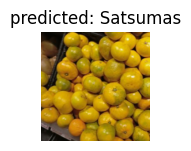

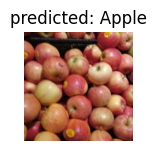

In [22]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().


In [23]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.1107 Acc: 0.5644
val Loss: 0.5698 Acc: 0.7895

Epoch 1/24
----------
train Loss: 0.9324 Acc: 0.6252
val Loss: 0.6532 Acc: 0.6842

Epoch 2/24
----------
train Loss: 0.6586 Acc: 0.7467
val Loss: 0.5133 Acc: 0.8246

Epoch 3/24
----------
train Loss: 0.6313 Acc: 0.7748
val Loss: 0.4859 Acc: 0.7719

Epoch 4/24
----------
train Loss: 0.6691 Acc: 0.7615
val Loss: 0.5636 Acc: 0.7544

Epoch 5/24
----------
train Loss: 0.6354 Acc: 0.7585
val Loss: 0.5250 Acc: 0.8070

Epoch 6/24
----------
train Loss: 0.5528 Acc: 0.8044
val Loss: 0.5737 Acc: 0.8070

Epoch 7/24
----------
train Loss: 0.4426 Acc: 0.8311
val Loss: 0.4829 Acc: 0.8596

Epoch 8/24
----------
train Loss: 0.4615 Acc: 0.8222
val Loss: 0.4845 Acc: 0.8246

Epoch 9/24
----------
train Loss: 0.4037 Acc: 0.8711
val Loss: 0.4915 Acc: 0.8246

Epoch 10/24
----------
train Loss: 0.4462 Acc: 0.8252
val Loss: 0.4539 Acc: 0.8246

Epoch 11/24
----------
train Loss: 0.4411 Acc: 0.8385
val Loss: 0.4457 Acc: 0.8596

Ep

<ipython-input-13-e5688ae9ca81>:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


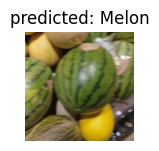

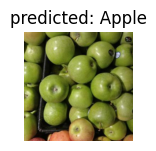

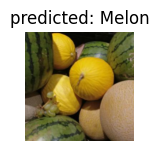

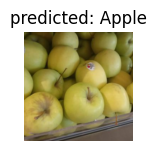

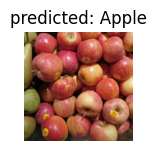

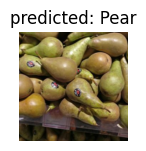

In [25]:
visualize_model(model_conv)

plt.ioff()
plt.show()

Inference on custom images
Use the trained model to make predictions on custom images and visualize the predicted class labels along with the images.

In [26]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

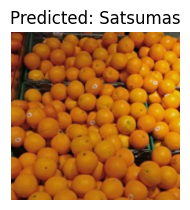

In [34]:
visualize_model_predictions(
    model_conv,
    img_path='/content/fruits_dataset/test/Orange/2172.jpg'
)

plt.ioff()
plt.show()

In [28]:
def evaluate_model(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects.double() / dataset_sizes['test']

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

# Evaluar
evaluate_model(model_ft)


Test Loss: 0.7696
Test Accuracy: 0.8336


In [29]:
precios_por_kg = {
    "Apple": 74,
    "Pear": 89,
    "Satsumas": 44,
    "Melon": 109,
    "Orange": 35
}

def calcular_costo(Y_real, Y_pred):
    if Y_pred > Y_real:
        return 5 * (Y_pred - Y_real)  # Usuario paga de más
    elif Y_pred < Y_real:
        return Y_real - Y_pred        # Usuario paga de menos
    else:
        return 0  # Escenario ideal


Y_real = precios_por_kg["Satsumas"]
Y_pred = precios_por_kg["Orange"]
costo = calcular_costo(Y_real, Y_pred)
print("Costo:", costo)

Costo: 9


In [30]:
def evaluate_model_with_cost(model):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_cost = 0.0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)


            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)


            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum().item()

            # Calcular el costo
            for i in range(len(labels)):
                Y_real = precios_por_kg[class_names[labels[i].item()]]
                Y_pred = precios_por_kg[class_names[preds[i].item()]]
                total_cost += calcular_costo(Y_real, Y_pred)

    test_loss = running_loss / dataset_sizes['test']
    test_acc = running_corrects / dataset_sizes['test']
    avg_cost = total_cost / dataset_sizes['test']

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    print(f'Cost: ${total_cost:.2f}')

#Evaluar
evaluate_model_with_cost(model_ft)

Test Loss: 0.7696
Test Accuracy: 0.8336
Cost: $6810.00


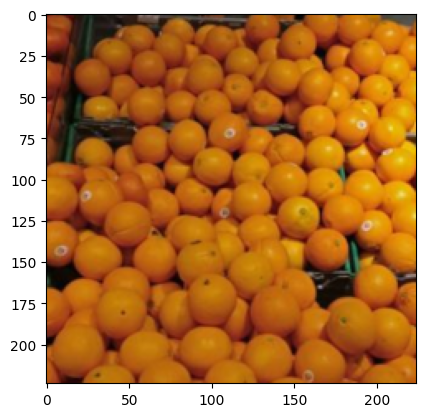

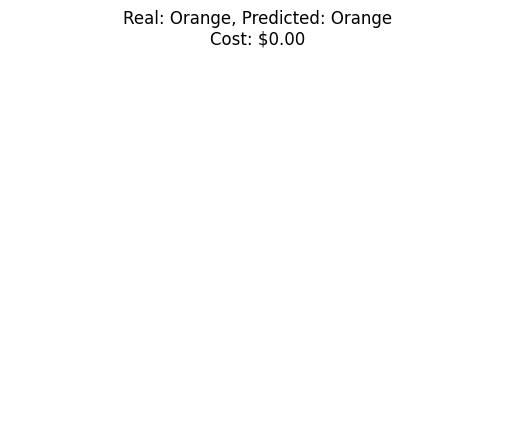

Real label: Orange
Predicted label: Orange
Cost: $0.00


In [31]:
def predict_and_calculate_cost(model, img_path, precios_por_kg):

    model.eval()


    img = Image.open(img_path).convert('RGB')
    img = data_transforms['test'](img).unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred_idx = torch.max(outputs, 1)
        pred_label = class_names[pred_idx.item()]


    true_label = os.path.basename(os.path.dirname(img_path))

    # Ccosto
    Y_real = precios_por_kg[true_label]
    Y_pred = precios_por_kg[pred_label]
    costo = calcular_costo(Y_real, Y_pred)

    imshow(img.cpu().squeeze())
    plt.title(f'Real: {true_label}, Predicted: {pred_label}\nCost: ${costo:.2f}')
    plt.axis('off')
    plt.show()


    print(f'Real label: {true_label}')
    print(f'Predicted label: {pred_label}')
    print(f'Cost: ${costo:.2f}')


predict_and_calculate_cost(model_ft, '/content/fruits_dataset/test/Orange/2172.jpg', precios_por_kg)


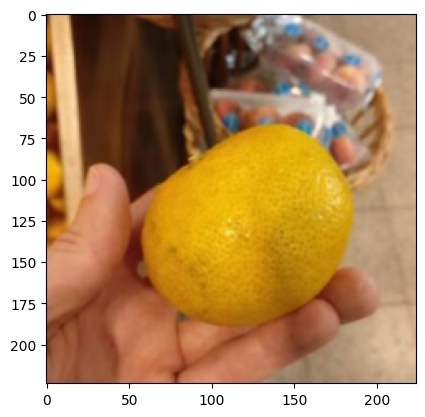

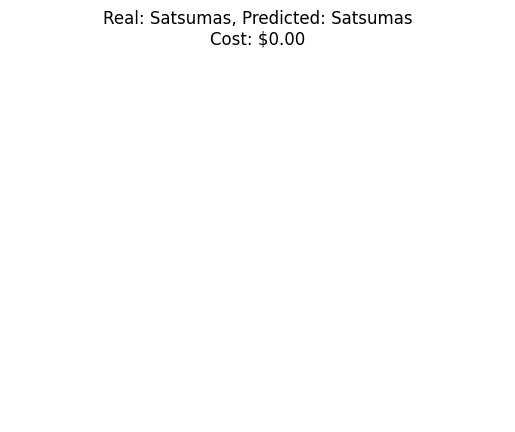

Real label: Satsumas
Predicted label: Satsumas
Cost: $0.00


In [32]:
predict_and_calculate_cost(model_ft, '/content/fruits_dataset/test/Satsumas/1930.jpg', precios_por_kg)

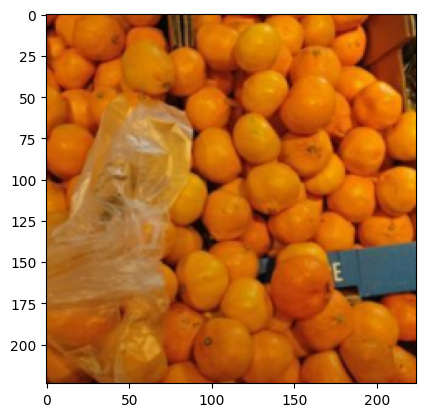

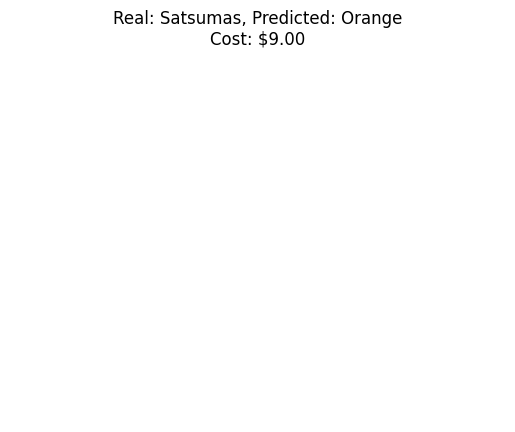

Real label: Satsumas
Predicted label: Orange
Cost: $9.00


In [33]:
predict_and_calculate_cost(model_ft, '/content/fruits_dataset/test/Satsumas/1922.jpg', precios_por_kg)